In [1]:
# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" #"1"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Hypothesis Testing Circuits

The primary tests we want to replicate are the faithfulness test (Equiavelance) and the minimality test (Minimality)

Faithfulness Test
- the full model and ablated model are equally likely to outpeform each other on a task
    - probability of the delta of the score function is greater then 0 - 1/2 is less than epsilon
    - use a sign test
    - test statistic is the # of times C* and M outperform each other 
    - test statistic is absolue value of the difference between the mean that the ablated model outpeforms the original model and 1/2
- P value (value of test statistic such that P(T > T_obs) = alpha) given by binomial distribution P(K > (T_obs + 1/2) * n | \theta = (1/2) + \epsilon)
    how do we choose epsilon?
    set to 0.1



# Minimal Faithful Circuit According to Attribution Score Ordering

In [2]:
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from transformer_lens import HookedTransformer

from auto_circuit.types import (
    CircuitOutputs, 
    BatchKey,
    PruneScores,
    PatchType, 
    AblationType,
    SrcNode, 
    DestNode, 
    Edge,
    Node
)
from auto_circuit.data import PromptPairBatch, PromptDataLoader   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.tasks import (
    Task,
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK,
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_TOKEN_CIRCUIT_TASK,
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK,
    GREATERTHAN_COMPONENT_CIRCUIT_TASK,  
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    CAPITAL_CITIES_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    docstring_true_edges
)
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.tensor_ops import batch_answer_diffs, batch_avg_answer_val
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.custom_tqdm import tqdm

from elk_experiments.auto_circuit.auto_circuit_utils import (
    run_circuits,
    desc_prune_scores, 
    prune_scores_threshold, 
    load_tf_model
)
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc, get_score_func

from elk_experiments.auto_circuit.circuit_hypotests import (
    equiv_test,
    sweep_search_smallest_equiv,
    plot_equivs_bar, 
    plot_num_ablated_C_gt_M, 
    plot_circuit_and_model_scores,
    compute_knees, 
    plot_edge_scores_and_knees,
    create_paths, 
    minimality_test, 
    plot_p_values, 
    plot_edge_k, 
    plot_score_quantiles
)
from elk_experiments.auto_circuit.circuit_hypotests import (
    get_edge_idx,
    make_complement_paths, 
    edges_from_mask, 
    minimality_test
)


NodeIdx = Tuple[int, int] # layer, head
def get_node_idx(node: DestNode) -> NodeIdx:
    return (node.layer, node.head_idx)

In [3]:

DOCSTRING_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK: Task = Task(
    key="Docstring Component Circuit",
    name="Docstring",
    _model_def="pythia-70m-deduped",
    _dataset_name="docstring_prompts",
    batch_size=2,
    batch_count=128,
    _true_edge_func=None,
    token_circuit=False,
    autoencoder_input="resid_delta_mlp",
    autoencoder_max_latents=200,
    autoencoder_pythia_size="2_32768",
    autoencoder_prune_with_corrupt=False,
)

from auto_circuit.metrics.official_circuits.circuits.ioi_official import (
    ioi_head_based_official_edges,
    ioi_true_edges,
)
IOI_TOKEN_CIRCUIT_TASK: Task = Task(
    key="Indirect Object Identification Token Circuit",
    name="Indirect Object Identification",
    _model_def="gpt2-small",
    _dataset_name="ioi/ioi_vanilla_template_prompts",
    batch_size=(60, 20),
    batch_count=(5, 5),
    _true_edge_func=ioi_head_based_official_edges,
    token_circuit=True,
)

In [4]:
task = DOCSTRING_TOKEN_CIRCUIT_TASK
token = True

task.init_task()

# docstring_task = DOCSTRING_COMPONENT_CIRCUIT_TASK
ablation_type = AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT
clean_corrupt = "corrupt" if ablation_type == AblationType.RESAMPLE else None 
alpha = 0.05
epsilon = 0.1 
q_star = 0.9
use_abs = False
side = None if use_abs else "left"
grad_function = GradFunc.LOGPROB
answer_function = AnswerFunc.AVG_VAL
grad_function_attrib = GradFunc.LOGPROB
answer_function_attrib = AnswerFunc.AVG_VAL

Loaded pretrained model attn-only-4l into HookedTransformer
seq_len before divergence 41
seq_len after divergence 30


In [5]:
# compute edge scores
# TODO: pass full model
attribution_scores = mask_gradient_prune_scores(
    model=task.model, 
    dataloader=task.train_loader,
    official_edges=None,
    grad_function=grad_function_attrib.value, #grad_function,
    answer_function=answer_function_attrib.value, #answer_function,
    mask_val=None, 
    ablation_type=ablation_type,
    integrated_grad_samples=10, # 10 1 for debugging
    clean_corrupt=clean_corrupt,
)

In [6]:
test_results, min_equiv = sweep_search_smallest_equiv(
    task.model, 
    task.test_loader,
    attribution_scores,
    grad_function, 
    answer_function,
    ablation_type=ablation_type,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon if use_abs else 0.0,
)

interval: 0 - 38430
width 1000


interval: 0 - 1000
width 100


interval: 0 - 100
width 10


interval: 20 - 30
width 1


In [7]:
assert min_equiv == min([k for k, v in test_results.items() if not v.not_equiv])
min_equiv

28

In [8]:
threshold = prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs)
edge_mask = {k: torch.abs(v) if use_abs else v >= threshold for k, v in attribution_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, token=token)


In [9]:
# accuracy, true positive
overlap = set(edges) & set(task.true_edges)
acc = len(overlap) / task.true_edge_count
tp = len(overlap) / len(edges)
acc, tp

(0.0031725049570389954, 0.8571428571428571)

In [10]:
# create edge dicts by src and dest
edges_by_dest: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in edges:
    edges_by_dest[get_node_idx(edge.dest)].append(edge)
    edges_by_src[get_node_idx(edge.src)].append(edge)
# creates edges to dest list
edges_to_dest: list[Edge] = []
# create edges to check queue
edges_to_check: list[Edge] = []
# add all edges with dest at resid end to edges to check
resid_end = next((dest for dest in task.model.dests if dest.name == "Resid End"), None)
edges_to_check.extend(edges_by_dest[get_node_idx(resid_end)])
checked: set[Node] = set()
# while len(edges_to_check) > 0
while len(edges_to_check) > 0:
    edge = edges_to_check.pop(0)
    # add edge to edges to dest
    edges_to_dest.append(edge)
    # get all edges with dest as src and add to edges to check (if not already chchedk)
    if edge.src in checked:
        continue
    for edge_to_check in edges_by_dest[get_node_idx(edge.src)]:
        # filter for queries not in same sequence 
        if (edge_to_check.dest.name.endswith("Q") or edge_to_check.dest.name.startswith("MLP")) and edge.seq_idx != edge_to_check.seq_idx:
            continue
        edges_to_check.append(edge_to_check)
    checked.add(edge.src)
print(len(edges_to_dest), len(edges))


19 28


In [11]:
def get_edge_idx(edge: Edge):
    if edge.dest.name == "Resid End":
        return (edge.seq_idx, edge.src.src_idx,)
    elif edge.dest.name.startswith("MLP"):
        return (edge.seq_idx, edge.src.src_idx)
    return (edge.seq_idx, edge.dest.head_idx, edge.src.src_idx)

In [12]:
# mask out all edges not in edges to dest
dead_end_score_mask = deepcopy(attribution_scores)
for edge in set(edges) - set(edges_to_dest):
    dead_end_score_mask[edge.dest.module_name][get_edge_idx(edge)] = 0.0

In [13]:
# from elk_experiments.auto_circuit.circuit_hypotests import equiv_test
# recompute equivalence 
pruned_result = equiv_test(
    task.model, 
    task.test_loader,
    dead_end_score_mask,
    grad_function,
    answer_function,
    ablation_type,
    thresholds=[threshold],
    model_out=None,
    full_model=None,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)[len(edges_to_dest)]

In [14]:
assert not pruned_result.not_equiv
assert torch.allclose(pruned_result.circ_scores, test_results[len(edges)].circ_scores, atol=1e-5)

In [15]:
zero_score_mask = {k: torch.zeros_like(v) for k, v in attribution_scores.items()}
pruned_zero_result = equiv_test(
    task.model, 
    task.test_loader,
    zero_score_mask,
    grad_function,
    answer_function,
    ablation_type,
    thresholds=[threshold],
    model_out=None,
    full_model=None,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)[0]

In [16]:
assert pruned_zero_result.not_equiv
assert not torch.allclose(pruned_zero_result.circ_scores, test_results[len(edges)].circ_scores, atol=1e-5)

In [17]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=dead_end_score_mask,
    score_threshold=prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs),
    show_all_seq_pos=True,
    orientation="h",
    use_abs=False,
    seq_labels=task.test_loader.seq_labels,
)

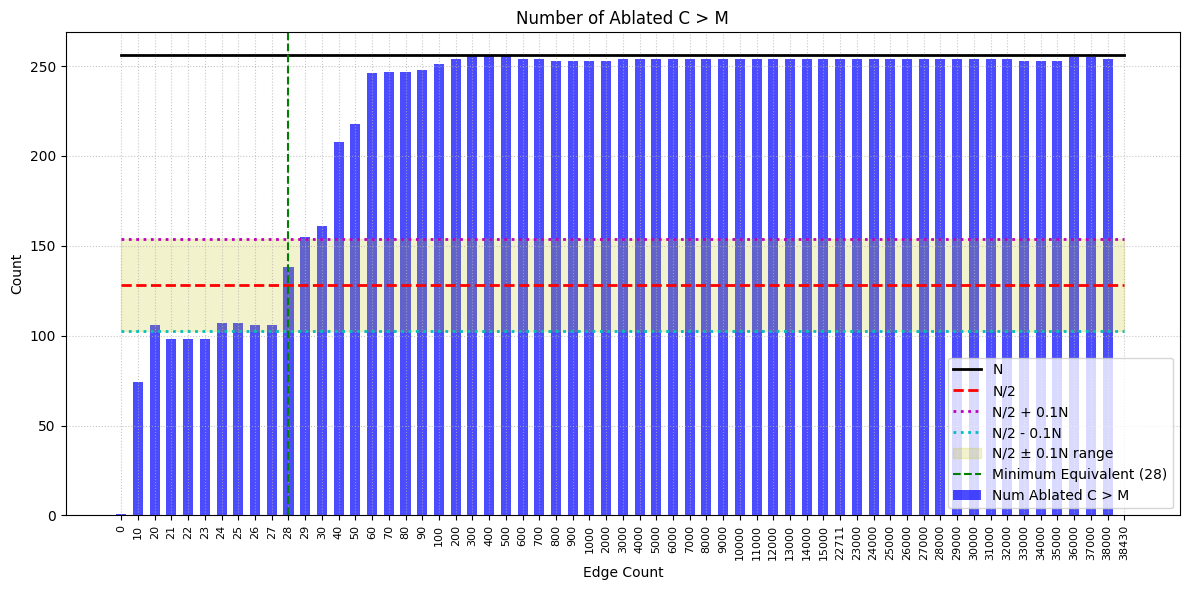

In [18]:
fig, ax = plot_num_ablated_C_gt_M(test_results, epsilon=epsilon if use_abs else 0.10, min_equiv=min_equiv)

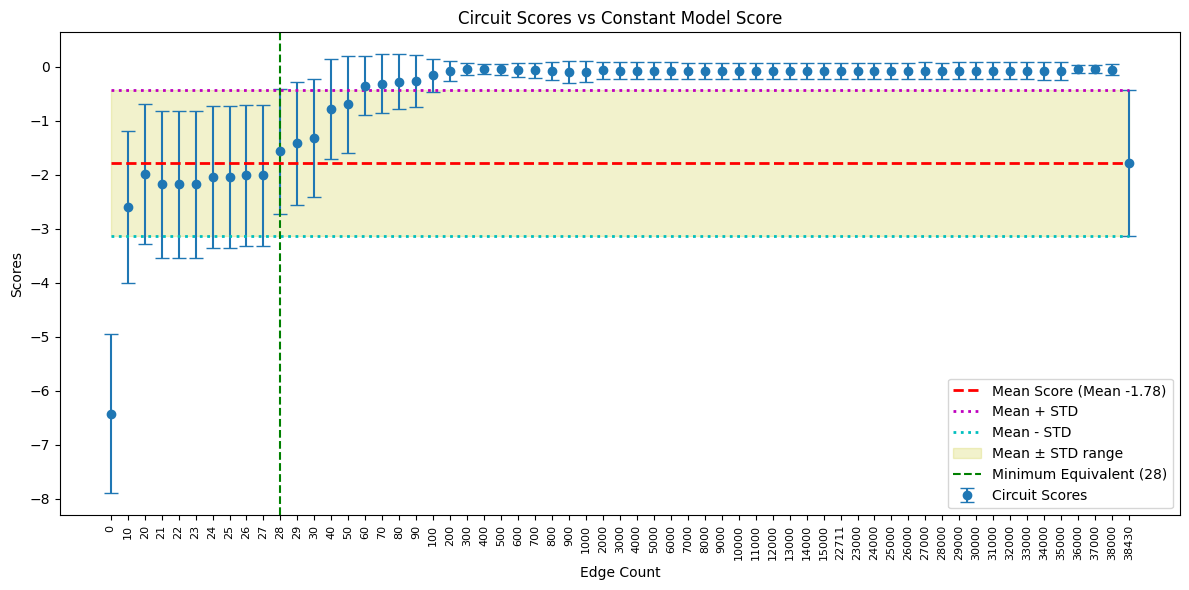

In [19]:
fig, ax = plot_circuit_and_model_scores(test_results, min_equiv)

In [20]:
def plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv):
    fig, ax = plt.subplots()
    ax.plot(edge_scores)
    # log axis 
    ax.set_yscale('log')
    ax.axvline(kneedle_poly.knee, color='r', linestyle='--', label="knee poly")
    ax.axvline(kneedle_1d.knee, color='g', linestyle='--', label="knee 1d")
    # plot min_equiv 
    ax.axvline(len(edge_scores) - min_equiv, color='b', linestyle='--', label="min equiv")
    ax.legend()
    return fig, ax

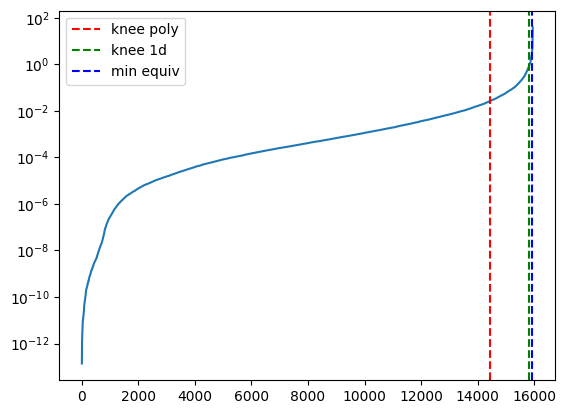

In [21]:
# plot attribution scores 
import numpy as np
edge_scores = np.flip(desc_prune_scores(attribution_scores, use_abs=use_abs).detach().cpu().numpy())
if not use_abs:
    edge_scores = edge_scores[edge_scores > 0]
kneedle_poly, kneedle_1d = compute_knees(edge_scores)
fig, ax = plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv)

In [22]:
round(len(edge_scores) - kneedle_poly.knee), round(len(edge_scores) - kneedle_1d.knee), min_equiv

(1526, 143, 28)

# Minimality Test

In [23]:
max_seq_idx = max([edge.seq_idx for edge in task.model.edges if edge.dest.name == "Resid End"])
max_seq_idx

29

In [24]:
from collections import defaultdict
last_seq_idx = max([src.seq_idx for src in task.model.edges])
srcs = task.model.srcs
dests = task.model.dests
max_layer = max([dest.layer for dest in dests])
# hmm I think sampling a path is exactly the smae

# screen out edges with dest layers 
# filter out edges to resid end that are not in last sequence
# valid_edges = [edge for edge in task.model.edges if 
#                not (edge.dest.name == "Resid End" and edge.seq_idx != last_seq_idx) and 
#                (edge.dest.layer < max_layer - 3 or edge.seq_idx == last_seq_idx or edge.dest.name.endswith(("K", "V")))]

# get edges by src and dest
edges_by_dest_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in task.model.edges:
    edges_by_dest_idx[get_node_idx(edge.dest)].append(edge)
    edges_by_src_idx[get_node_idx(edge.src)].append(edge)

In [25]:
# sample path using topological sort + dynamic programming to get number of paths from each parent node, and sample according to proportion of paths 

from dataclasses import dataclass

@dataclass(frozen=True)
class SeqNode(Node):
    seq_idx: int | None = None

    def __repr__(self) -> str:
        return self.name + "_" + str(self.seq_idx)

    def __str__(self) -> str:
        return self.name + "_" + str(self.seq_idx)

def node_to_seq_node(node: Node, seq_idx: int) -> SeqNode:
    return SeqNode(
        name=node.name,
        module_name=node.module_name,
        layer=node.layer,
        head_idx=node.head_idx,
        head_dim=node.head_dim,
        seq_idx=seq_idx,
    )

start_node = next(src for src in task.model.srcs if src.name == "Resid Start")
dests_to_seq_dests: dict[DestNode, list[SeqNode]] = {
    dest: [node_to_seq_node(dest, seq_idx) for seq_idx in range(last_seq_idx + 1)]
    for dest in list(dests) + [start_node]
}

In [26]:
def valid_node(node: SeqNode) -> bool:
    return node.layer < max_layer - 2 or node.seq_idx == last_seq_idx or node.name.endswith(("K", "V"))

In [27]:
# construct graph and compute path counts
graph: dict[SeqNode: list[SeqNode]] = defaultdict(list[SeqNode])
nodes = set()
path_counts: dict[SeqNode, int] = defaultdict(int)

# sort dests by layer
for dest in tqdm(sorted(list(task.model.dests) + [start_node], key=lambda x: x.layer, reverse=True)):
    # construct seq node dest from dest for each seq_idx 
    seq_nodes = dests_to_seq_dests[dest]
    for seq_node in seq_nodes:
        # if dest is mlp or q and layer is >= max_layers - 2, skip  
        if not valid_node(seq_node):
            continue
        nodes.add(seq_node)
        # if dest is resid end, add to graph and set path count to 1, and skp
        if dest.name == "Resid End":
            graph[seq_node] = []
            path_counts[seq_node] = 1
            continue 
            # if dest is K, V 
        # get downstream edges from dest
        edges = edges_by_src_idx[get_node_idx(dest)]
        if dest.name.endswith(("K", "V")):
            # if dest.layer >= max_layer - 2 (last layer or two layers dependnign on whether attention and mlp are counted together)
            if dest.layer >= max_layer - 2:
                # convert edge dests to seq nodes with seq_idx = max_seq_idx
                child_dests = [dests_to_seq_dests[edge.dest][max_seq_idx] for edge in edges]
            else:
                # convert edge dests to all seq nodes
                child_dests = [seq_dest for edge in edges for seq_dest in dests_to_seq_dests[edge.dest]]
        # else (q or mlp)
        else: 
            # already checked if valid, but checking again
            assert valid_node(seq_node)
            # convet edge dests to all seq nodes with same seq_idx
            child_dests = [dests_to_seq_dests[edge.dest][seq_node.seq_idx] for edge in edges]
        # filter for valid child nodes
        graph[seq_node] = [child_dest for child_dest in child_dests if valid_node(child_dest)]
        path_counts[seq_node] = sum([path_counts[child_dest] for child_dest in child_dests])

In [32]:
max_layers = max([node.layer for node in task.model.nodes])
max_layers

5

In [42]:
end_graph = {k: v for k, v in graph.items() if k.layer > 3}  # 21
end_graph_path_counts = {k: v for k, v in path_counts.items() if k.layer > 3}

sg_max_layer = 2
start_graph = {k: [v for v in vs if v.layer < sg_max_layer] for k, vs in graph.items() if k.layer < sg_max_layer}
start_graph_path_counts = {k: v for k, v in path_counts.items() if k.layer < sg_max_layer}
sum([len(v) for v in end_graph.values()]), sum([len(v) for v in start_graph.values()])

(14640, 21600)

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def visualize_graph(graph, path_counts, sort_by_head: bool=True):
    # Create a new directed graph
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for source, targets in graph.items():
        G.add_node(str(source), layer=source.layer, seq_idx=source.seq_idx, head_idx=source.head_idx)
        for target in targets:
            G.add_edge(str(source), str(target))

    # Set up the plot
    plt.figure(figsize=(24, 16))
    
    # Create a custom layout for the graph
    pos = {}
    seq_idx_set = sorted(set(data['seq_idx'] for _, data in G.nodes(data=True)))
    layer_set = sorted(set(data['layer'] for _, data in G.nodes(data=True)))  # No longer reversed
    
    # Group nodes by layer and seq_idx
    grouped_nodes = defaultdict(list)
    for node, data in G.nodes(data=True):
        grouped_nodes[(data['layer'], data['seq_idx'])].append((node, data))

    # Calculate layout
    column_width = 1.5  # Adjust this value to increase horizontal spacing
    row_height = 5  # Adjust this value to increase vertical spacing
    max_nodes_in_group = max(len(nodes) for nodes in grouped_nodes.values())
    
    for (layer, seq_idx), nodes in grouped_nodes.items():
        x = seq_idx_set.index(seq_idx) * column_width
        y = (len(layer_set) - 1 - layer_set.index(layer)) * row_height  # Invert y-axis
        
        # Sort nodes by head_idx (if available) or by node name
        if sort_by_head:
            sorted_nodes = sorted(nodes, key=lambda n: (n[1]['head_idx'] if n[1]['head_idx'] is not None else float('inf'), n[0]))
        else: # sort by Q, K, V, MLP
            sorted_nodes = sorted(nodes, key=lambda n: (n[0].split('_')[0].split('.')[-1]))
        
        # Position nodes in a vertical line within their layer and seq_idx group
        for i, (node, data) in enumerate(sorted_nodes):
            node_y = y - i * (row_height / (max_nodes_in_group + 1))  # Distribute nodes evenly within the row
            pos[node] = (x, node_y)

    # Draw the nodes
    node_size = 100  # Adjust as needed
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='lightblue')

    # Draw the edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=0.5, arrowsize=10)

    # Add labels to the nodes
    labels = {node: f"{node.split('_')[0]}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=6)

    # Add path counts as labels on the nodes (uncomment if needed)
    # path_count_labels = {str(node): f"Paths: {count}" for node, count in path_counts.items()}
    # nx.draw_networkx_labels(G, pos, path_count_labels, font_size=4, font_color='red')

    plt.title("Graph Visualization with Corrected Layer Spacing")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

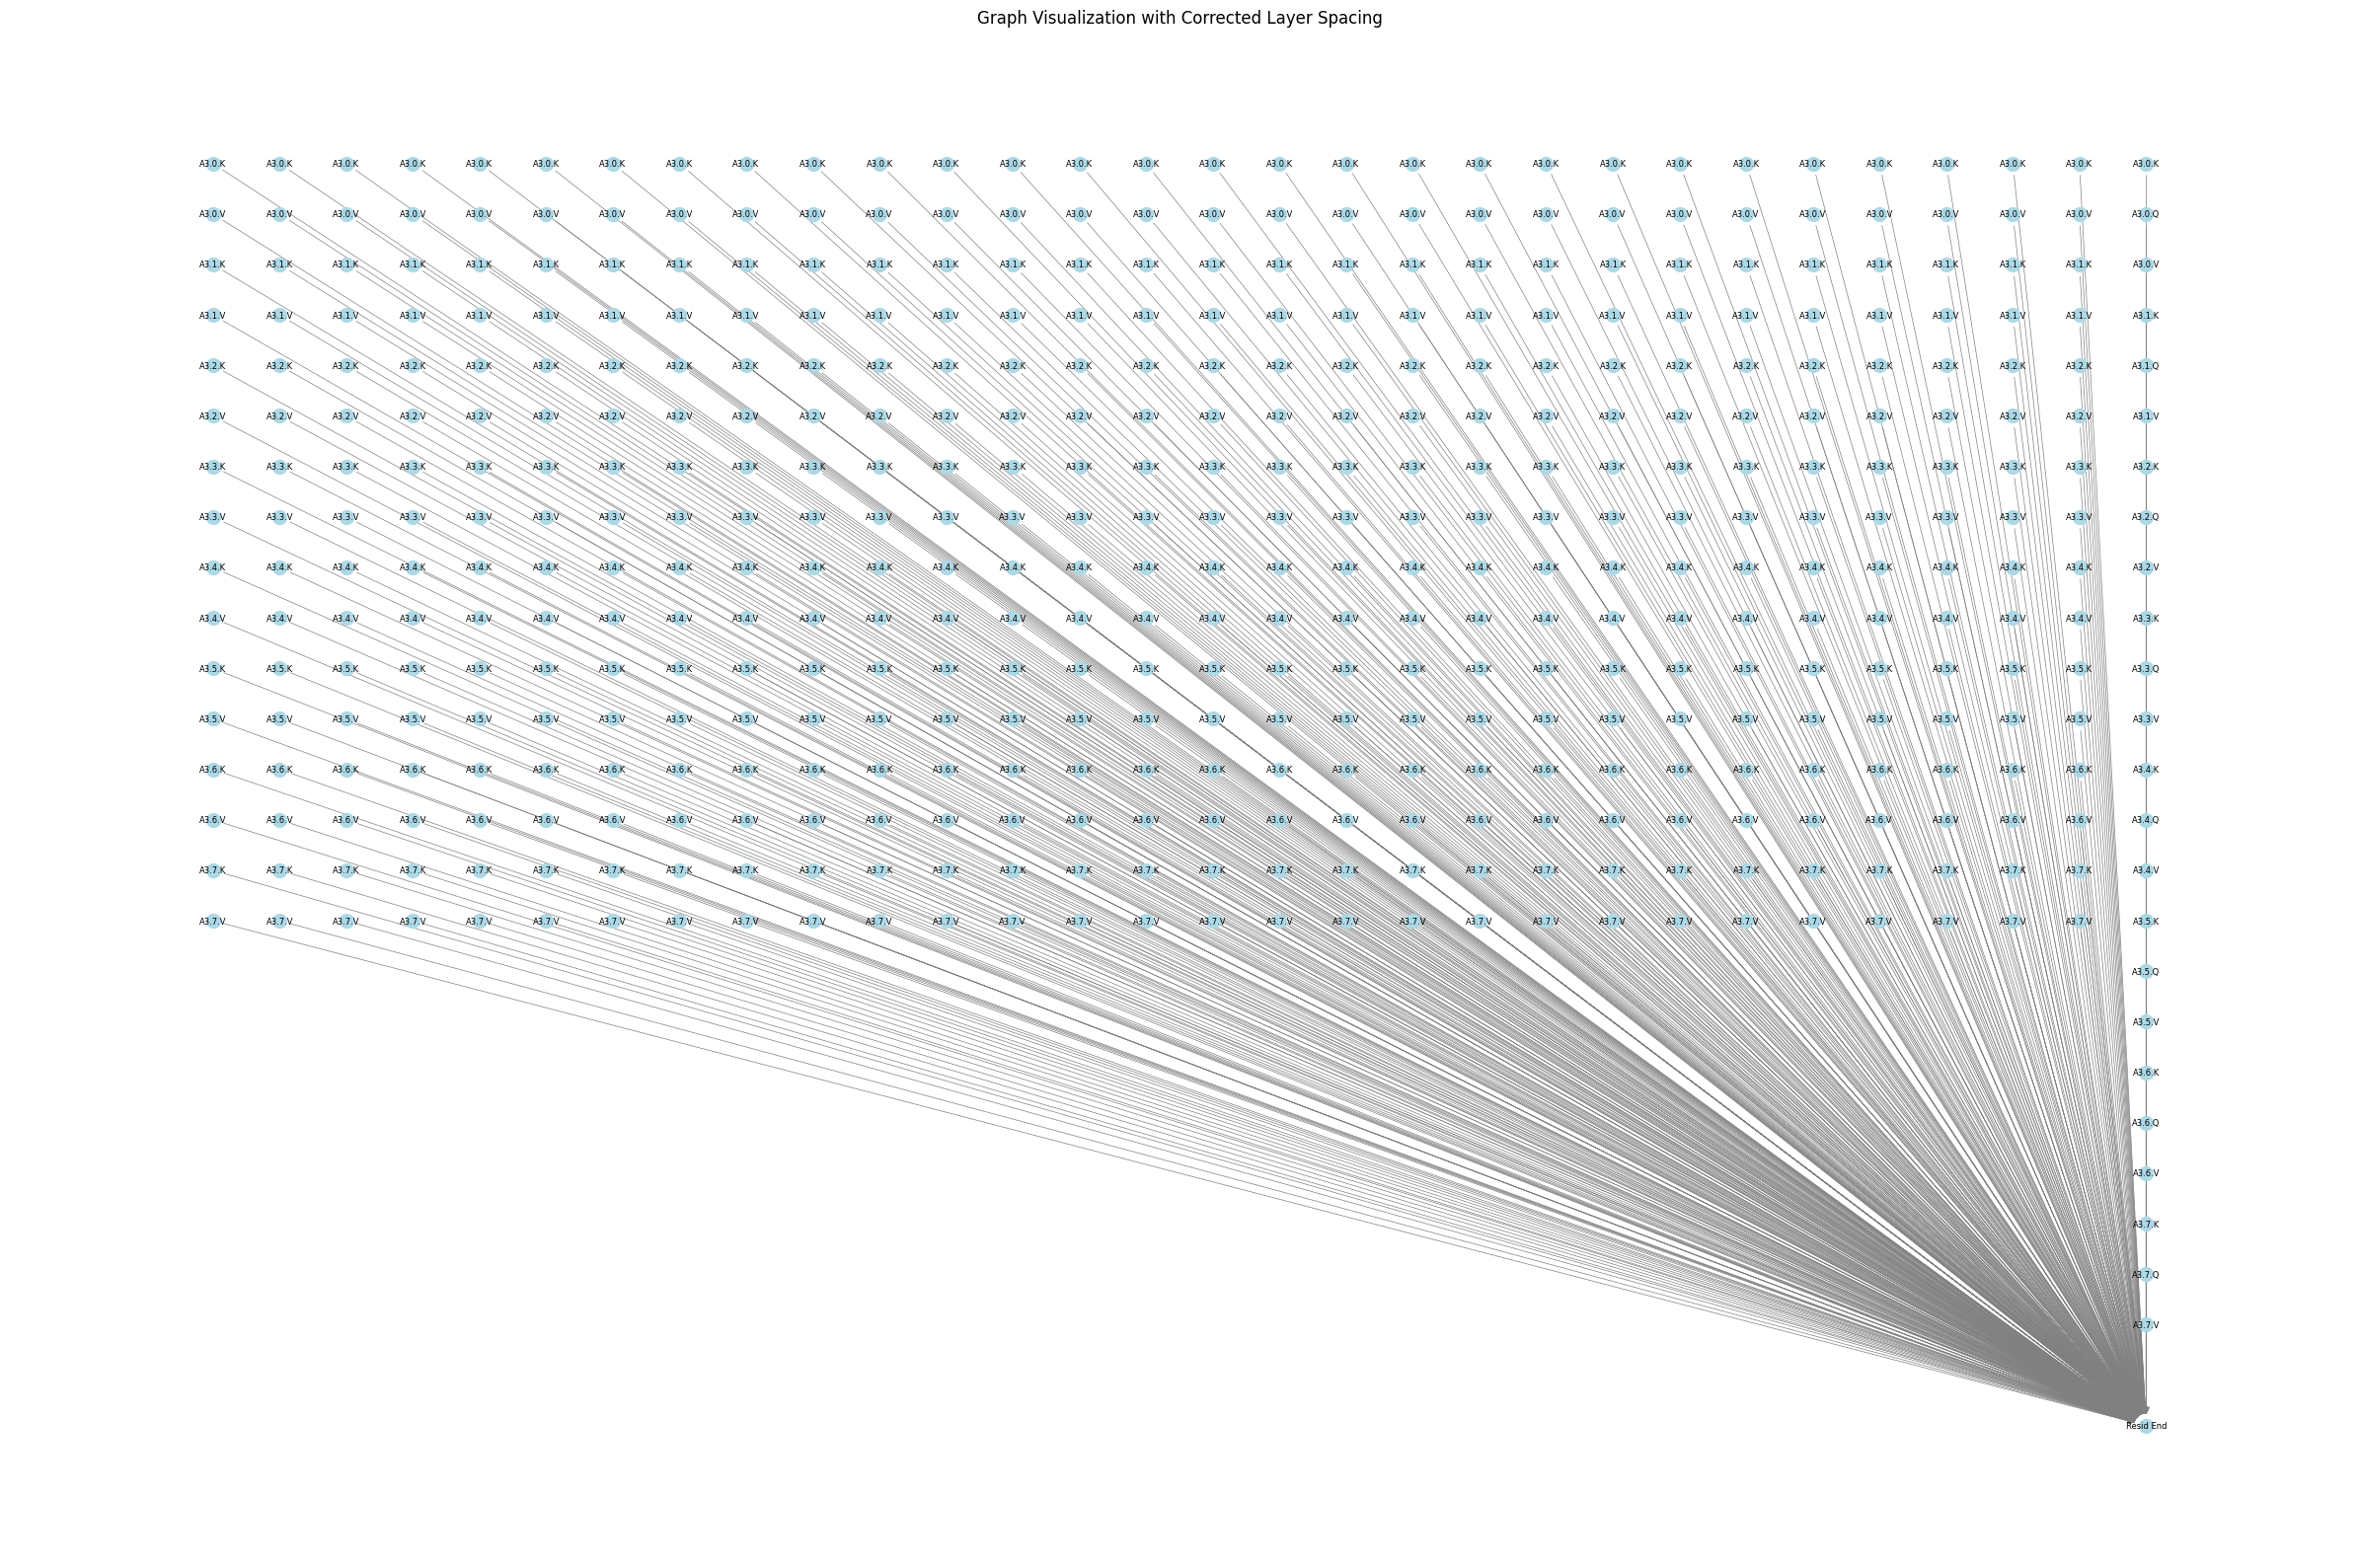

In [38]:
# end of graph
visualize_graph(end_graph, end_graph_path_counts)

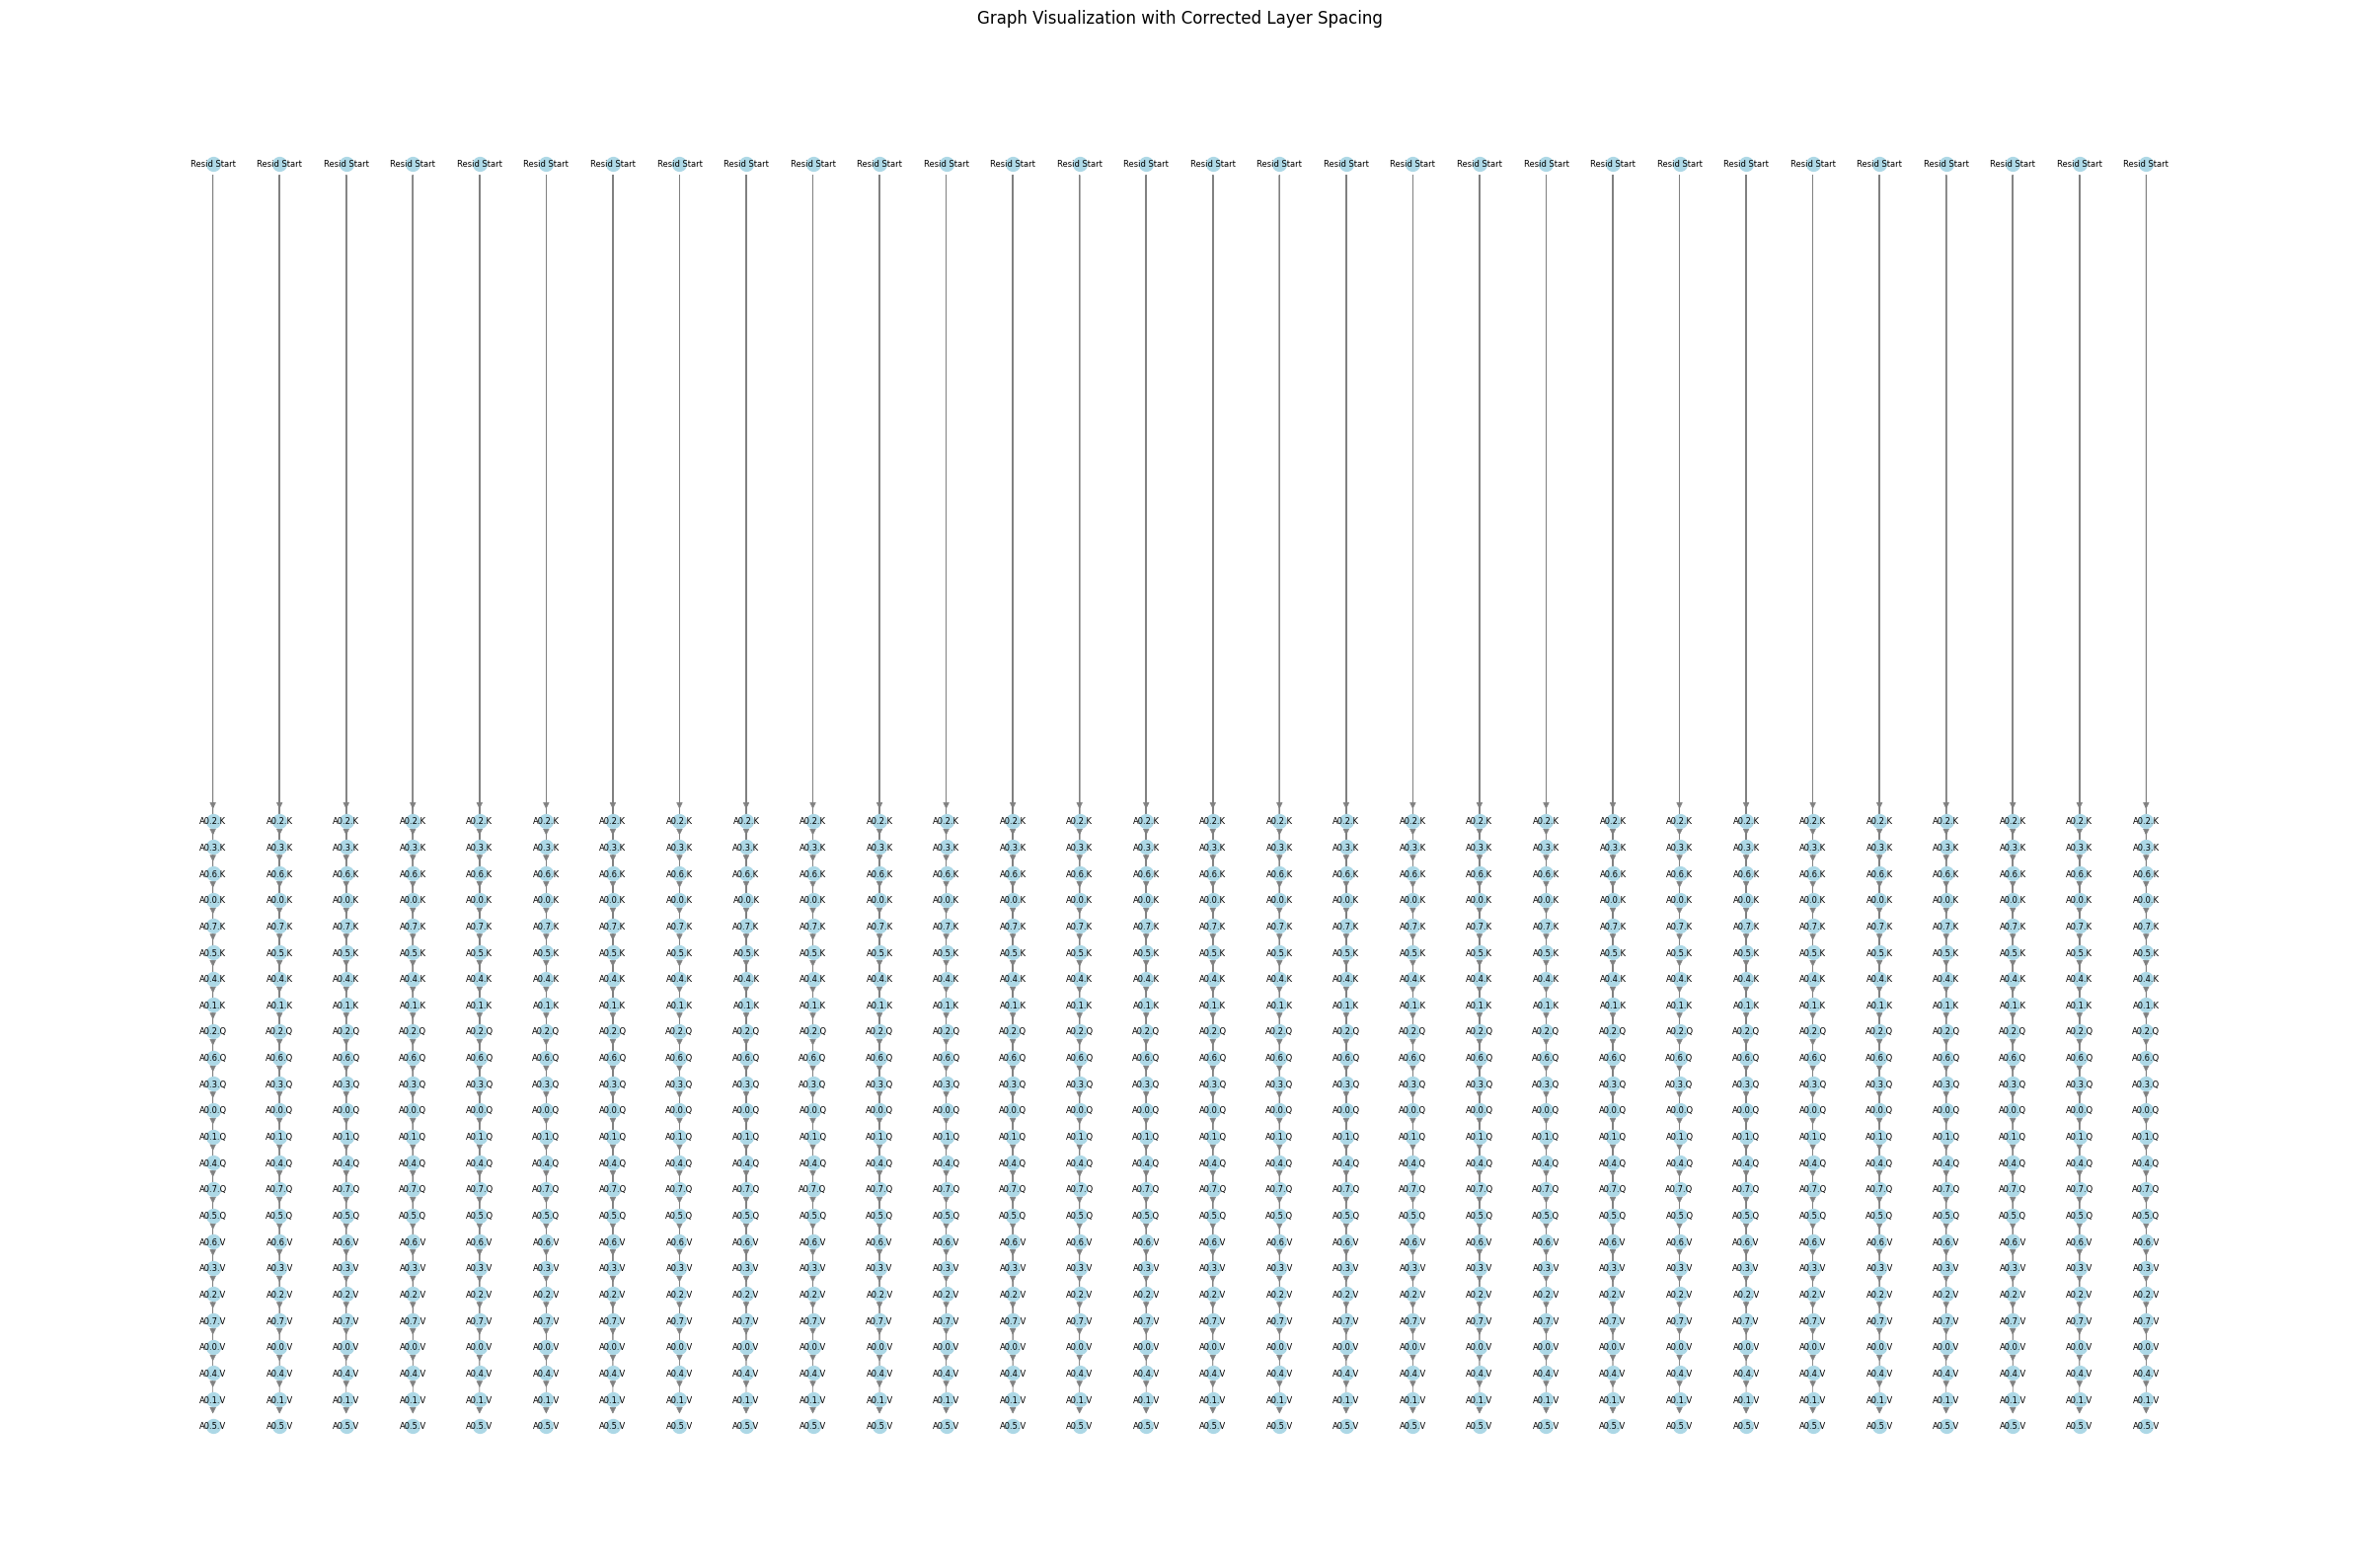

In [40]:
# start of graph
visualize_graph(start_graph, start_graph_path_counts, sort_by_head=False)

In [43]:
# sample path
sorted_nodes = sorted(list(nodes), key=lambda x: x.layer)
def sample_path():
    path = []
    current = random.choice(sorted_nodes[:max_seq_idx]) # resid starts
    path.append(current)
    while current.name != "Resid End":
        neighbors = graph[current]
        probs = [path_counts[neighbor] / path_counts[current] for neighbor in neighbors]
        current = random.choices(graph[current], weights=probs)[0] 
        path.append(current)
    return path 

In [94]:
# src_from_idx: dict[NodeIdx, SrcNode] = {get_node_idx(src): src for src in task.model.srcs}
# dest_from_idx: dict[NodeIdx, DestNode] = {get_node_idx(dest): dest for dest in task.model.dests}


In [44]:
sampled_path = sample_path()

In [45]:
# convert sequence dest nodes to edges 
dest_pairs_to_edges: dict[Tuple[int, int|None, str, int|None, int]: Edge] = {}
for edge in task.model.edges:
    dest_pairs_to_edges[(*get_node_idx(edge.src), edge.dest.name, edge.dest.head_idx, edge.seq_idx)] = edge

In [46]:
def dest_path_to_edge_path(dest_path: list[SeqNode]) -> list[Edge]:
    edge_path = []
    for i in range(len(dest_path) - 1):
        dest_src = dest_path[i]
        dest_dest = dest_path[i + 1]
        edge = dest_pairs_to_edges[(*get_node_idx(dest_src), dest_dest.name, dest_dest.head_idx, dest_dest.seq_idx)]
        edge_path.append(edge)
    return edge_path

In [47]:
tested_edges = edges_to_dest
tested_scores = dead_end_score_mask

n_paths = 256 
filtered_paths = []
for _ in tqdm(range(n_paths)):
    path = dest_path_to_edge_path(sample_path())
    while not any((edge not in tested_edges for edge in path)):
        path = dest_path_to_edge_path(sample_path())
    filtered_paths.append(path)

In [48]:
# sort edges
edge_scores = {edge: tested_scores[edge.dest.module_name][get_edge_idx(edge)] for edge in tested_edges}
tested_edges = sorted(edge_scores.keys(), key=lambda x: abs(edge_scores[x]), reverse=False)

In [50]:
tokens = True

In [57]:
[s.shape for s in tested_scores.values()] # seq_idx, head_idx, src_idx

[torch.Size([30, 8, 17]),
 torch.Size([30, 8, 1]),
 torch.Size([30, 8, 25]),
 torch.Size([30, 8, 17]),
 torch.Size([30, 8, 1]),
 torch.Size([30, 8, 9]),
 torch.Size([30, 8, 9]),
 torch.Size([30, 8, 9]),
 torch.Size([30, 8, 17]),
 torch.Size([30, 8, 25]),
 torch.Size([30, 33]),
 torch.Size([30, 8, 25]),
 torch.Size([30, 8, 1])]

In [58]:
# run minimality test
min_test_results = minimality_test(
    task.model, 
    task.test_loader,
    attribution_scores,
    tested_edges, 
    filtered_paths,
    min_equiv,
    ablation_type,
    grad_function,
    answer_function,
    threshold=threshold,
    tokens=tokens,
    alpha=alpha, 
    q_star=q_star
)

IndexError: index 6 is out of bounds for dimension 3 with size 1

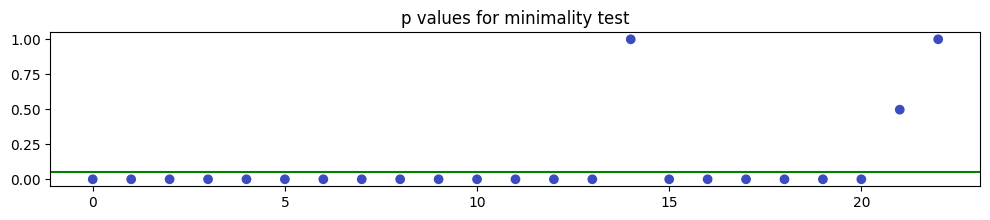

In [ ]:
# plot p values as scatter plot
fig, ax = plot_p_values(min_test_results, tested_edges, edge_scores)


In [ ]:
len(next(iter(min_test_results.values())).diffs)

2

(<Figure size 1200x200 with 1 Axes>,
 <Axes: title={'center': 'k for minimality test'}>)

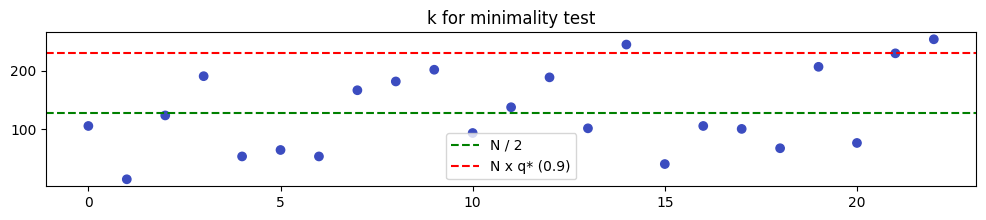

In [ ]:
# plot frac of n 
plot_edge_k(min_test_results, tested_edges, edge_scores, task.batch_size * task.batch_count, q_star=q_star)


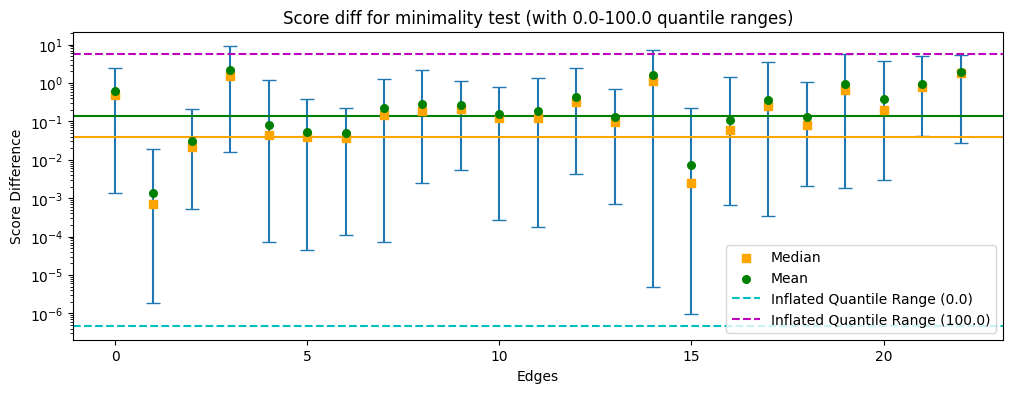

In [ ]:
# plot average diff 
fit, ax = plot_score_quantiles(min_test_results, tested_edges, edge_scores, quantile_range=[0.00, 1.00])
